In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [2]:
from scipy import signal
from scipy.fft import fftshift
from scipy.io.wavfile import read

In [3]:
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from xgboost import XGBClassifier

In [4]:
import librosa
from librosa.feature import melspectrogram, mfcc

In [5]:
from typing import List, Tuple

In [6]:
from audio_utils import *

In [7]:
Categories=['Cough', 'Sneeze']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='data/input/' 

In [8]:
spectrogram_array = []
target_array = []
for i in Categories:
    print(f'loading... category : {i}')
    path = os.path.join(datadir, i)
    for sound in os.listdir(os.path.join(datadir,i)):
        if sound.endswith('.wav'):
            spectrogram_array.append(get_spectrogram(os.path.join(path, sound)))
            # spectrogram_array.append(get_spectrogram(os.path.join(path, sound)))
            target_array.append(Categories.index(i))
    print(f'loaded category:{i} successfully')

loading... category : Cough
loaded category:Cough successfully
loading... category : Sneeze
loaded category:Sneeze successfully


In [9]:
def get_maximum_shape(array_list: List[np.ndarray]) -> Tuple[int, int]:
    max_height = max_width = 0
    for arr in array_list:
        max_height = max(max_height, arr.shape[0])
        max_width = max(max_width, arr.shape[1])
    return max_height, max_width

In [10]:
max_height, max_width = get_maximum_shape(spectrogram_array)

In [11]:
flat_data_list = [pad_spectrogram(np_array=spec, target_size_w=max_width, target_size_h=max_height).flatten() for spec in spectrogram_array]

In [12]:
flat_data=np.array(flat_data_list, dtype=object)
target=np.array(target_array, dtype=int)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target

In [13]:
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

## Classification part

In [14]:
list_param_c = [0.01, 0.1, 1]
list_param_nu = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
list_param_gamma = [0.00001, 0.0001, 0.001]
list_param_kernel = ['linear', 'rbf', 'poly', 'sigmoid']
list_param_degree = [2, 3, 4, 5]

In [15]:
list_param_max_depth = [2, 3, 4, 5, 6]

In [16]:
param_grid_svc = {'C':list_param_c,'gamma':list_param_gamma,'kernel':list_param_kernel}
param_grid_nu_svc = {'nu':list_param_nu,'gamma':list_param_gamma,'kernel':list_param_kernel}

In [17]:
param_grid_tree = {'max_depth': list_param_max_depth}

In [18]:
svc = SVC(probability=True)
model_svc = GridSearchCV(svc, param_grid_svc)

In [30]:
nu_svc = NuSVC(probability=True, max_iter=200)
model_nu_svc = GridSearchCV(nu_svc, param_grid_nu_svc)

In [20]:
model_tree = GridSearchCV(DecisionTreeClassifier, param_grid_tree)

In [21]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)
print('Splitted Successfully')

Splitted Successfully


In [22]:
model_svc.fit(x_train,y_train)
print('The Model (SVC) is trained well with the given images')
# model.best_params_ contains the best parameters obtained from GridSearchCV

The Model (SVC) is trained well with the given images


In [23]:
y_pred = model_svc.predict(x_test)

In [24]:
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The model is 87.5% accurate


In [25]:
np.set_printoptions(precision=2)

In [26]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

Confusion matrix, without normalization
[[26  0]
 [ 0 30]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


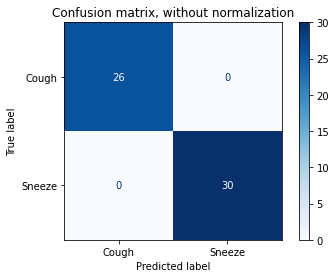

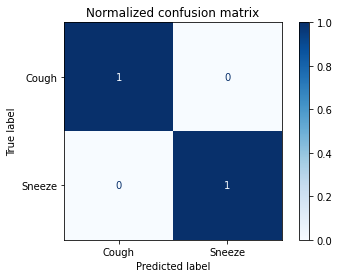

In [27]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_svc,
        x_test,
        y_pred,
        display_labels=Categories,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [28]:
# print best parameter after tuning
print(model_svc.best_params_)

{'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear'}


In [29]:
# print how our model looks after hyper-parameter tuning
print(model_svc.best_estimator_)

SVC(C=0.01, gamma=1e-05, kernel='linear', probability=True)


In [31]:
model_nu_svc.fit(x_train, y_train)
print('The Model (NuSVC) is trained well with the given images')
# model.best_params_ contains the best parameters obtained from GridSearchCV

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).

The Model (NuSVC) is trained well with the given images


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [32]:
y_pred_nu = model_nu_svc.predict(x_test)
print(f"The model is {accuracy_score(y_pred_nu,y_test)*100}% accurate")

The model is 82.14285714285714% accurate


In [33]:
model_tree.fit(x_train, y_train)
print('The Model (Tree) is trained well with the given images')
# model.best_params_ contains the best parameters obtained from GridSearchCV

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.